<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw1_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
'''!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul'''

'!if [ -d deepul ]; then rm -Rf deepul; fi\n!git clone https://github.com/rll/deepul.git \n!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/\n!pip install ./deepul'

In [ ]:
!cp -r drive/My\ Drive/dul/* .

In [ ]:
!mkdir -p deepul/homeworks/hw1/data/

In [ ]:
!unzip data/hw1_data.zip -d deepul/homeworks/hw1/data/

Archive:  data/hw1_data.zip
  inflating: deepul/homeworks/hw1/data/geoffrey-hinton.jpg  
  inflating: deepul/homeworks/hw1/data/mnist_colored.pkl  
  inflating: deepul/homeworks/hw1/data/mnist.pkl  
  inflating: deepul/homeworks/hw1/data/shapes_colored.pkl  
  inflating: deepul/homeworks/hw1/data/shapes.pkl  
  inflating: deepul/homeworks/hw1/data/smiley.jpg  


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from tqdm.autonotebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


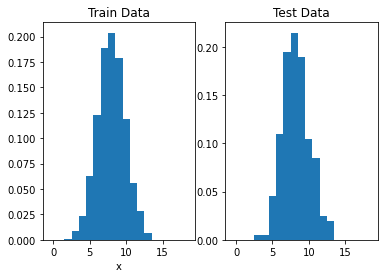

Dataset 2


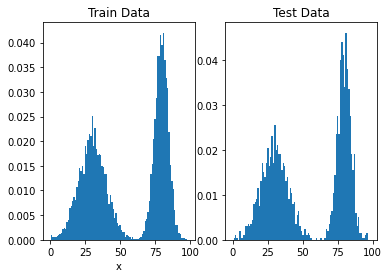

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{99}) \in \mathbb{R}^{100}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,99\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [ ]:
class HistogramModel(nn.Module):
    def __init__(self, dim_size):
        super().__init__()
        self.dim_size = dim_size
        self.logits = nn.Parameter(torch.zeros(dim_size))
        self.loss_func = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax(dim=0)

    def compute_loss(self, x):
        x = x.long()
        logits = self.logits[None, :].repeat(x.shape[0], 1) # repeat along batch_size
        return self.loss_func(logits, x)

    def predict_distribution(self):
        distribution = self.softmax(self.logits)
        return distribution.detach().cpu().numpy()

class Trainer:
    def __init__(self, model, train_loader, test_loader, num_epochs=10, lr=1e-2, clip_grad=2):
        self.model = model
        self.optimizer = Adam(model.parameters(), lr)
        self.lr = lr
        self.clip_grad = clip_grad
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        train_losses = []
        test_losses = [self.eval_epoch()]
        pbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in pbar:
            epoch_losses = self.train_epoch()
            train_losses.extend(epoch_losses)

            test_loss = self.eval_epoch()
            test_losses.append(test_loss)
            
            pbar.set_postfix_str(f'Epoch #{epoch}, test loss: {test_loss:.4f}')

        return train_losses, test_losses

    def train_epoch(self):
        self.model.train()
        
        train_losses = []
        for x in self.train_loader:
            loss = self.model.compute_loss(x.to(device).contiguous())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            train_losses.append(loss.item())
        return train_losses

    def eval_epoch(self):
        self.model.eval()

        total_loss = 0
        with torch.no_grad():
            for x in self.test_loader:
                loss = self.model.compute_loss(x.to(device).contiguous())
                total_loss += loss * x.shape[0]

        return (total_loss / len(self.test_loader.dataset)).item()

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  model = HistogramModel(d).to(device)
  train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=256)
  trainer = Trainer(model, train_loader, test_loader, 30, 1e-1)
  
  train_losses, test_losses = trainer.train()

  distribution = model.predict_distribution()

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results




Final Test Loss: 2.0676


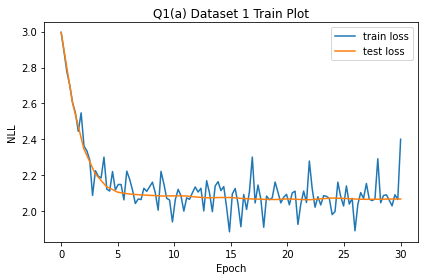

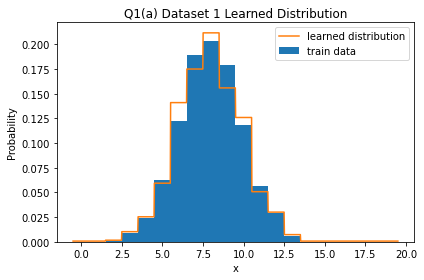

In [ ]:
q1_save_results(1, 'a', q1_a)


Final Test Loss: 4.0367


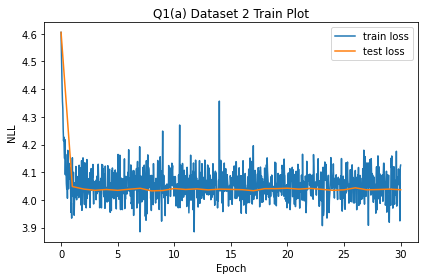

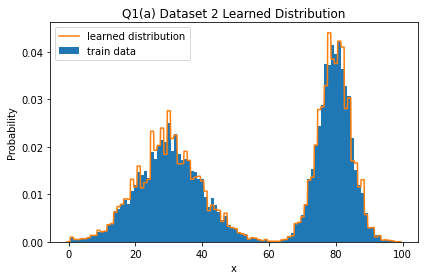

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MixtureModel(nn.Module):
    def __init__(self, dim_size, num_mix=4, eps=1e-12):
        super().__init__()
        self.dim_size = dim_size
        self.num_mix = num_mix
        self.eps = eps

        self.logits = nn.Parameter(torch.empty(num_mix))
        self.log_s = nn.Parameter(torch.empty(num_mix))
        self.mu = nn.Parameter(torch.empty(num_mix))
        
        for p in (self.logits, self.log_s, self.mu):
            nn.init.xavier_uniform_(p.view(-1, 1))

        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = x[:, None].repeat(1, self.num_mix).float()
        pi = self.softmax(self.logits)[None, :]
        s = torch.exp(self.log_s)[None, :]
        mu = self.mu[None, :]

        delta = torch.sigmoid((x + 0.5 - mu) / s) - \
                torch.sigmoid((x - 0.5 - mu) / s)
        delta = torch.where(
            x <= self.eps,
            torch.sigmoid((0.5 - mu) / s),
            delta
        )
        delta = torch.where(
            x >= self.dim_size - 1 - self.eps,
            1 - torch.sigmoid((self.dim_size - 1.5 - mu) / s),
            delta
        )

        return torch.logsumexp(
            torch.log(delta.clamp(min=self.eps)) + torch.log(pi.clamp(min=self.eps)), 
            dim=1
        )

    def compute_loss(self, x):
        return -torch.mean(self.forward(x))

    def predict_distribution(self):
        with torch.no_grad():
            x = torch.arange(self.dim_size).to(device)
            distribution = self.forward(x).exp()
        return distribution.detach().cpu().numpy()


In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  model = MixtureModel(d).to(device)
  train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=1024)
  trainer = Trainer(model, train_loader, test_loader, 200, 1e-1, clip_grad=5)
  
  train_losses, test_losses = trainer.train()

  distribution = model.predict_distribution()

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results




Final Test Loss: 2.0595


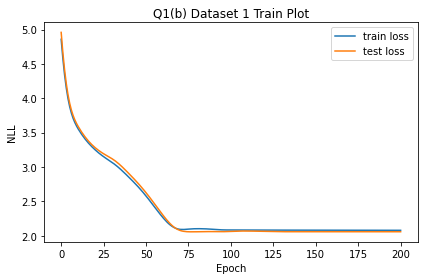

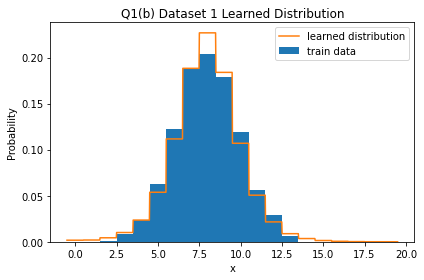

In [ ]:
q1_save_results(1, 'b', q1_b)


Final Test Loss: 4.0352


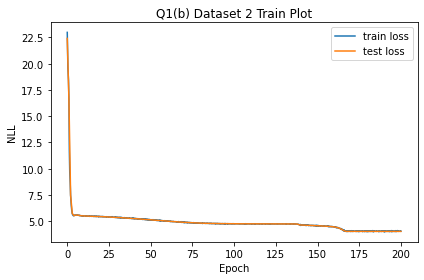

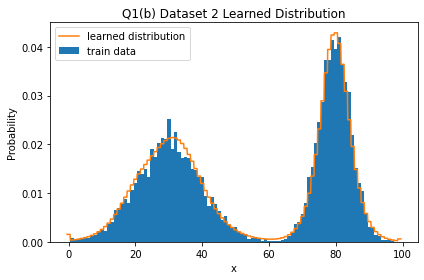

In [ ]:
q1_save_results(2, 'b', q1_b)